In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw

In [2]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import double_fluid_gel_fem
importlib.reload(double_fluid_gel_fem)

import utils 
importlib.reload(utils)

from ngsolve.webgui import Draw

In [ ]:
def plot_frame(n_samples, rho, rho2, vx, vy, nx, ny, title, stride=3, save=True):
    X = np.linspace(0, 1, n_samples)
    Y = np.linspace(0, 1, n_samples)
    X, Y = np.meshgrid(X, Y)

    # Plot the contour for rho_vals
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    im0 = axes[0].contourf(X, Y, rho, levels=100, cmap='Greys')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].contourf(X, Y, rho2, levels=100, cmap='Greys')
    fig.colorbar(im1, ax=axes[1])

    mag = np.sqrt(vx**2+vy**2)
    im2 = axes[2].contourf(X, Y, mag, levels=100, cmap='Blues')
    axes[2].set_title('v')
    fig.colorbar(im2, ax=axes[2])
    axes[2].quiver(X[::stride, ::stride], Y[::stride, ::stride], 
            (vx/mag)[::stride, ::stride], (vy/mag)[::stride, ::stride], 
            color='orange', 
            width=0.003,     # Increase width to make arrow shafts thicker
            headwidth=4,     # Increase headwidth for wider arrowheads
            headlength=5,    # Increase headlength for longer arrowheads
            headaxislength=7 # Increase headaxislength for more pronounced heads
    ) 

    mag = np.sqrt(nx**2+ny**2)
    im3 = axes[3].contourf(X, Y, mag, levels=100, cmap='Blues')
    axes[3].set_title('nematic order')
    fig.colorbar(im3, ax=axes[3])
    axes[3].quiver(X[::stride, ::stride], Y[::stride, ::stride], 
            (nx/mag)[::stride, ::stride], (ny/mag)[::stride, ::stride], 
            color='orange', 
            width=0.003,     # Increase width to make arrow shafts thicker
            headlength=0,    
            headaxislength=0 
    ) 

    axes[0].set_title(title)
    plt.tight_layout()
    if save:
        plt.savefig(f"{title}.png", dpi=300)
    plt.show()

def run_sim(eta, beta1, beta2, chi0_active, chi1_active, k_actin, T, source):
    sim = double_fluid_gel_fem.DoubleActinGel2D(
                    width=1, height=1, maxh=0.03,
                    gamma=eta, eta_1=eta, eta_2=0,
                    k=1, k_actin=k_actin,
                    D=1e-4, kappa =1e-3,
                    beta1 = beta1, beta2 = beta2,   
                    chi0 = chi0_active,  chi1 = chi1_active,
                    Qsq = -1 + 2*source, 
                    rho0 = 1*source,
                    rho0_actin=1*(1-source))
    
    for i in range(len(sim.density.vec.data)): 
        sim.density.vec.data[i] = np.random.normal(1, 0.01)
        sim.nematic_xx.vec.data[i] = np.random.normal(0, 0.01)

    sim.simulate(
        tend=T,
        tau=0.05,
        save_interval=20 # save once a second 
    )

    return sim 

tanh = lambda arg: (exp(arg) - exp(-arg))/(exp(arg)+exp(-arg)) 
left_edge = 0.5 - 0.06
right_edge = 0.5 + 0.06
left_transition = 0.5 * (tanh((x - left_edge)/0.01))
right_transition = 0.5 * (tanh((right_edge - x)/0.01))

bottom_transition = 0.5 * (tanh((y - 0.1)/0.1))
top_transition = 0.5 * (tanh((0.9 - y)/0.1))
source =1*(left_transition + right_transition) *(top_transition + bottom_transition)


In [6]:
eta = 1 
k_actin = 0.1 
beta_prod = 1
beta2 = 1
beta1 = beta_prod/beta2
eta = 1 

T = 100 

In [ ]:
# skip this block if you want to use the precomputed data
n_samples = 50 
exponents = np.linspace(np.log(0.01), 0, 50)
chis = np.exp(exponents)



for chi0_active in chis:
    for chi1_active in chis:          
        # for k_actin in [0.1, 0.2, 0.5]:
        filename = 'sim_data/two_actin/chi0_{}_chi1_{}_kact_{}.npy'.format(chi0_active, chi1_active, k_actin)
        if not os.path.isfile(filename):
            sim = run_sim(eta, beta1, beta2, chi0_active, chi1_active, k_actin, T, source)
            n_samples = 40 
            _ = sim.export_to_npy(filename, n_samples=n_samples)

In [4]:
def extract_states(filename, shear_range=1): 
    data = np.load(filename)
    rho, rho2, vx, vy, Q, q = np.rollaxis(data[-1], -1)
    n_samples = rho.shape[0] 
    mid_x, mid_y = n_samples//2 -1, n_samples//2-1
    shear_discrete = (np.sign(vx[mid_y, mid_x+shear_range] - vx[mid_y, mid_x-shear_range]) - np.sign(vy[mid_y+shear_range, mid_x] - vy[mid_y-shear_range, mid_x]))/2
    Q_mid = Q[mid_x, mid_y]
    rho_diff = np.max(rho+rho2) - np.min(rho+rho2) 
    return np.array([rho_diff, shear_discrete, Q_mid])

In [7]:
n_samples = 50 
exponents = np.linspace(np.log(0.01), 0, 50)
chis = np.exp(exponents)

states = []  # Store rho_diff, shear, Q_mid
for chi0_active in chis:
    for chi1_active in chis:       
        filename = 'sim_data/two_actin/chi0_{}_chi1_{}_kact_{}.npy'.format(chi0_active, chi1_active, k_actin)

        if os.path.isfile(filename):
            states.append(extract_states(filename, shear_range=10))

states = np.array(states).reshape(len(chis), len(chis), 3)             

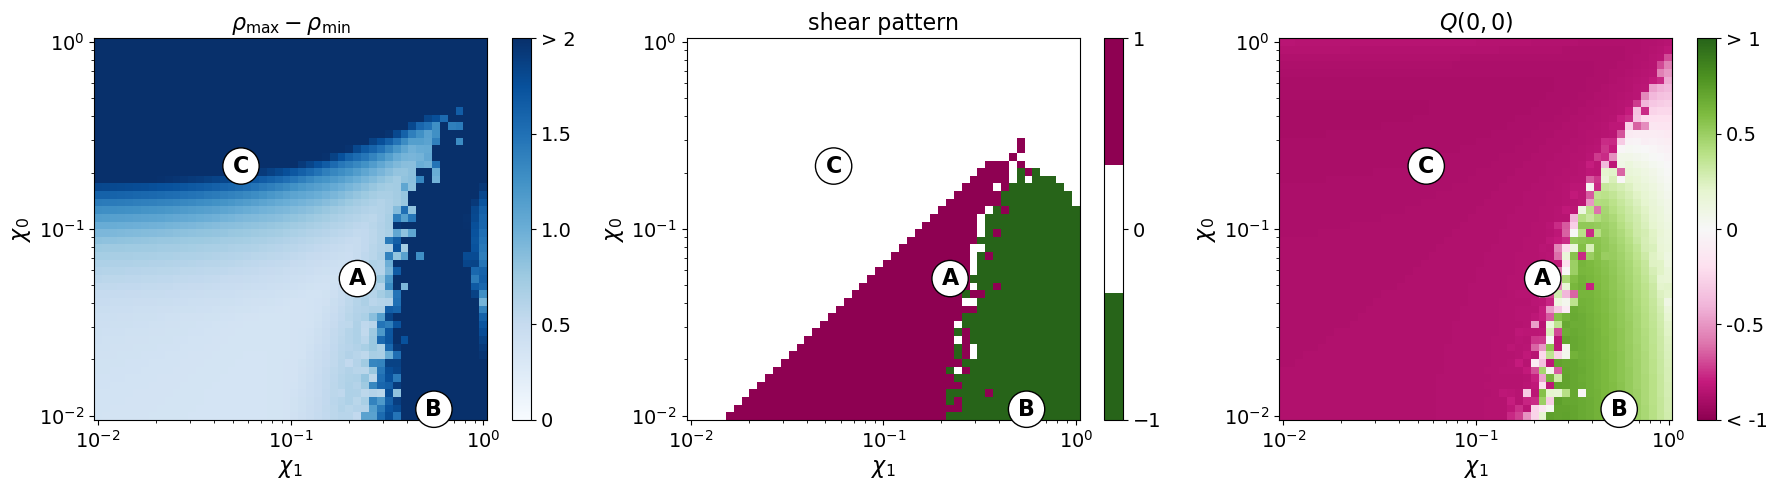

In [27]:
from matplotlib.colors import ListedColormap


param_sets = [
            [0.05, 0.2], 
            [0.01, 0.5], 
            [0.2, 0.05]
        ]
texts = ['A', 'B', 'C']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
names = [r'$\rho_\mathrm{max} - \rho_\mathrm{min}$', r'shear pattern', r'$Q(0, 0)$']
ranges = [(0, 2), (-1, 1), (-1, 1)]
import matplotlib.colors as mcolors

# Create discrete colormap for shear panel
shear_colors = ['#276419', 'white', '#8e0152']
shear_cmap = ListedColormap(shear_colors)

cmaps = ['Blues', shear_cmap, 'PiYG']
for i, ax in enumerate(axes):
    c = ax.pcolor(chis, chis, states[:, :, i], cmap=cmaps[i], vmin=ranges[i][0], vmax=ranges[i][1])
    ax.set_xlabel(r'$\chi_1$', fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(names[i], fontsize=16)
    ax.set_ylabel(r'$\chi_0$', fontsize=16)

    for j, (chi0, chi1) in enumerate(param_sets):
        ax.text(chi1, chi0, texts[j], fontsize=16, fontweight='bold', 
                bbox=dict(boxstyle="circle,pad=0.3", facecolor='white', edgecolor='black'))
    
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=14)

    cbar = fig.colorbar(c, ax=ax)
    # Increase colorbar tick label font size
    cbar.ax.tick_params(labelsize=14)
    
    # Custom labeling for each panel
    if i == 0:  # rho_diff panel
        cbar.set_ticks([0, 0.5, 1.0, 1.5, 2.0])
        cbar.set_ticklabels(['0', '0.5', '1.0', '1.5', '> 2'])
    elif i == 1:  # shear panel
        cbar.set_ticks([-1, 0, 1])
    elif i == 2:  # Q_mid panel
        cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
        cbar.set_ticklabels(['< -1', '-0.5', '0', '0.5', '> 1'])

plt.tight_layout()
plt.savefig('../figures/param_sweep.svg', dpi=500)
plt.show() 

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_95487/3512170284.py:20: RuntimeWarning: invalid value encountered in divide
  (vx/mag)[::stride, ::stride], (vy/mag)[::stride, ::stride],


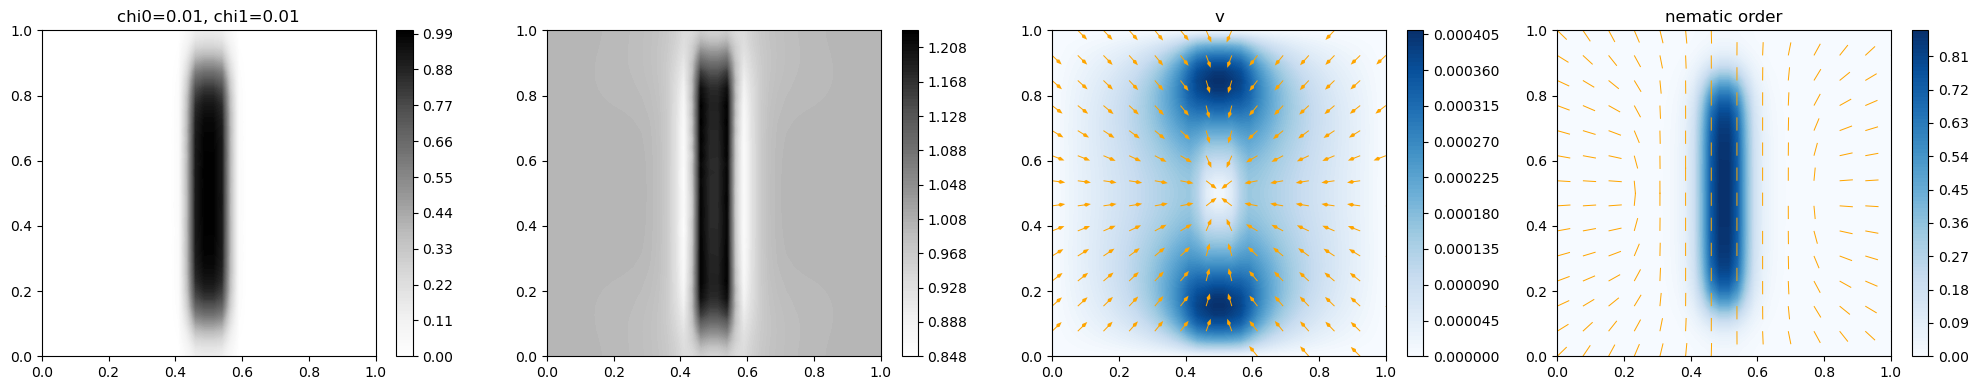

[ 0.37580072  0.         -0.87407234]


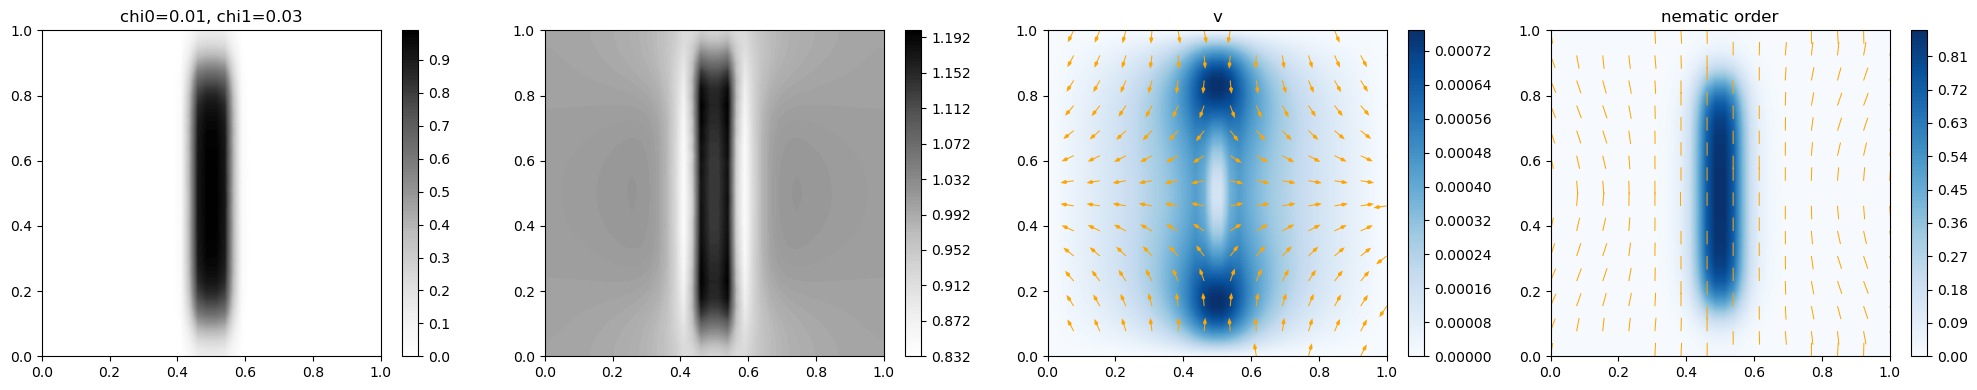

[ 0.36206255  1.         -0.87195122]


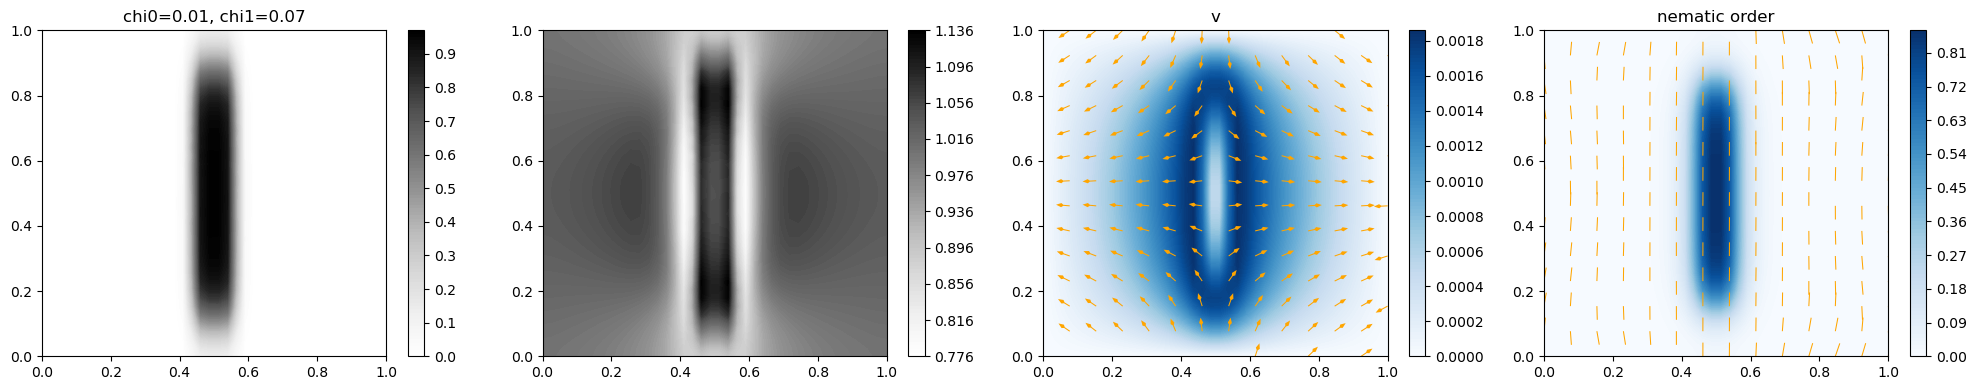

[ 0.3564762   1.         -0.86627657]


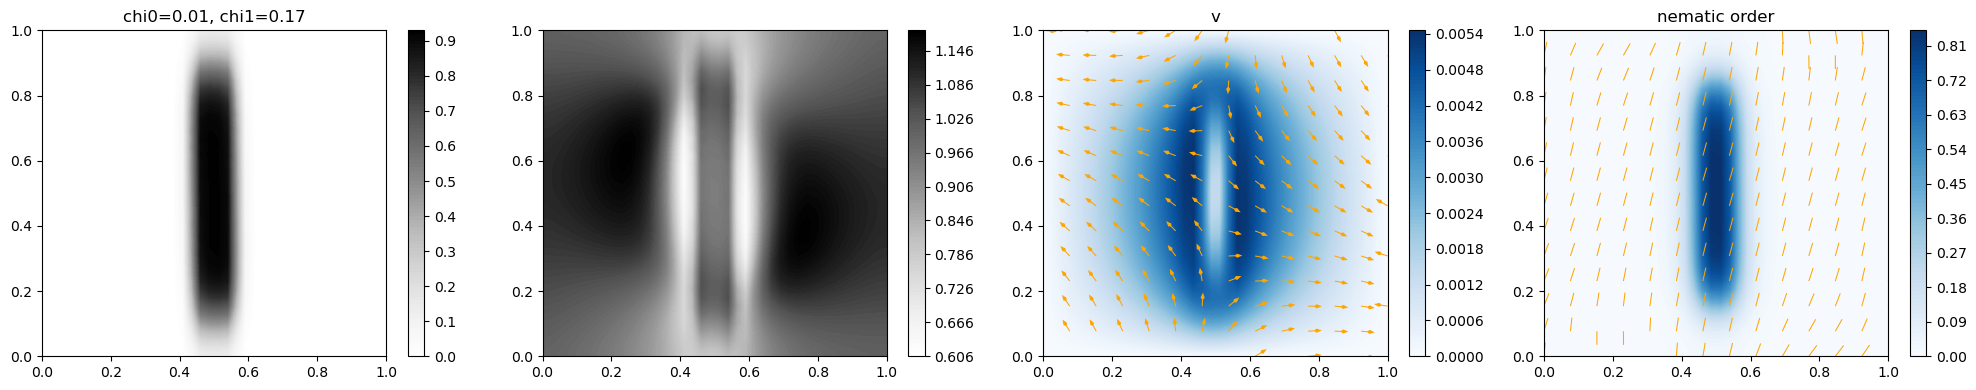

[ 0.56857132  1.         -0.71282129]


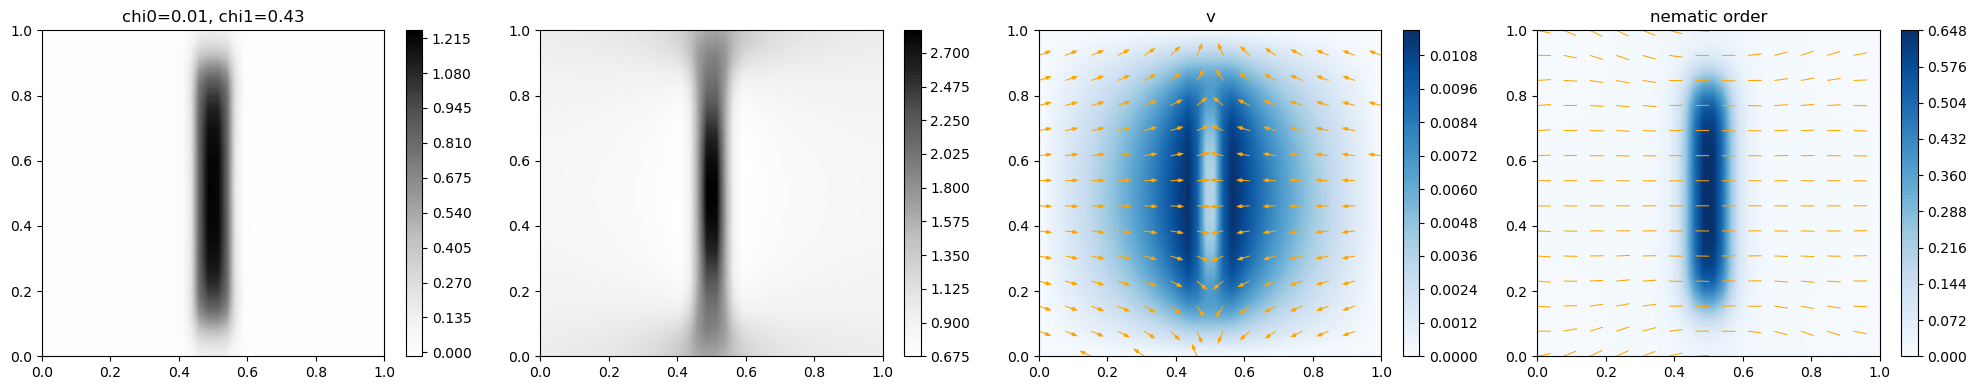

[ 2.16563385 -1.          0.64410314]


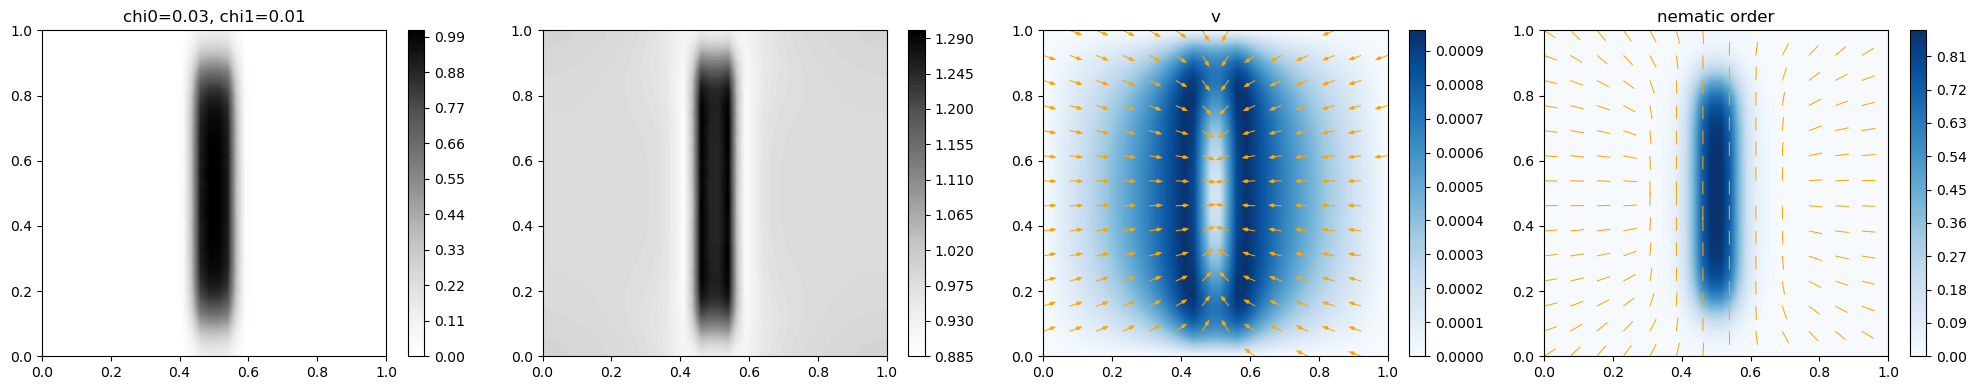

[ 0.4149499   0.         -0.87589703]


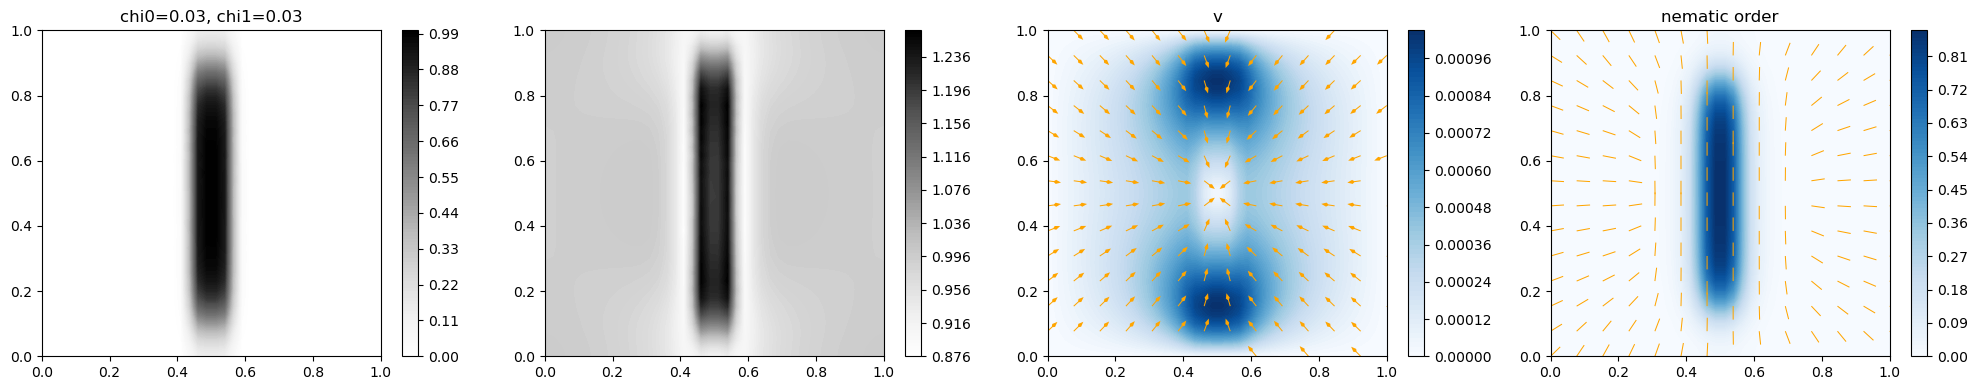

[ 0.38860487  0.         -0.87381463]


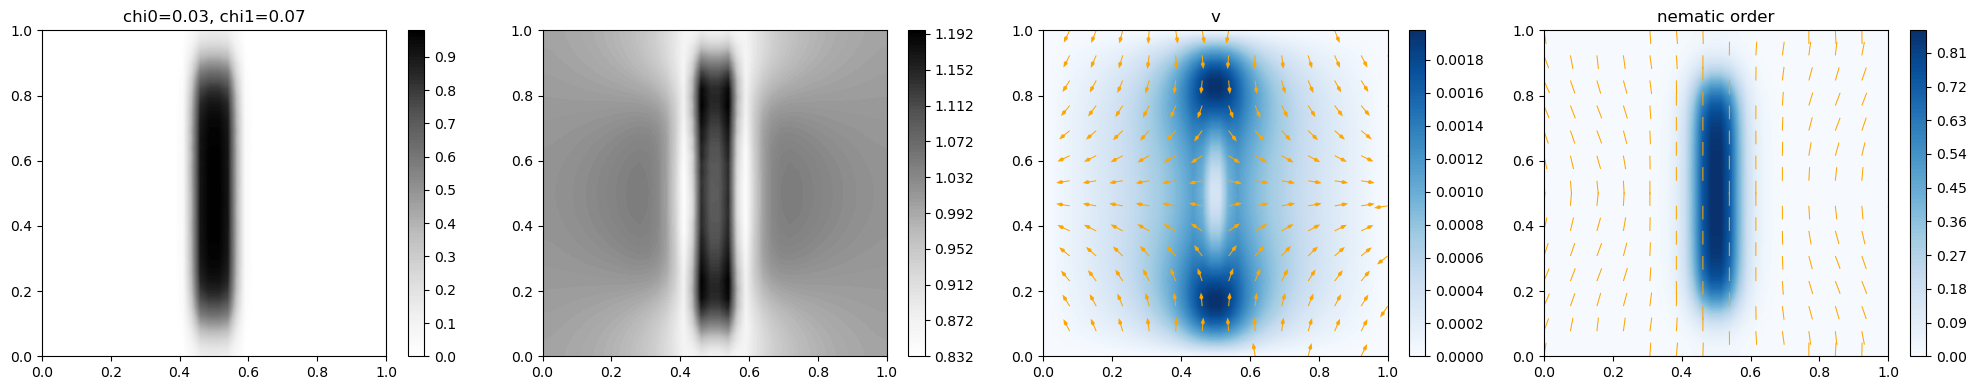

[ 0.36066404  1.         -0.86831704]


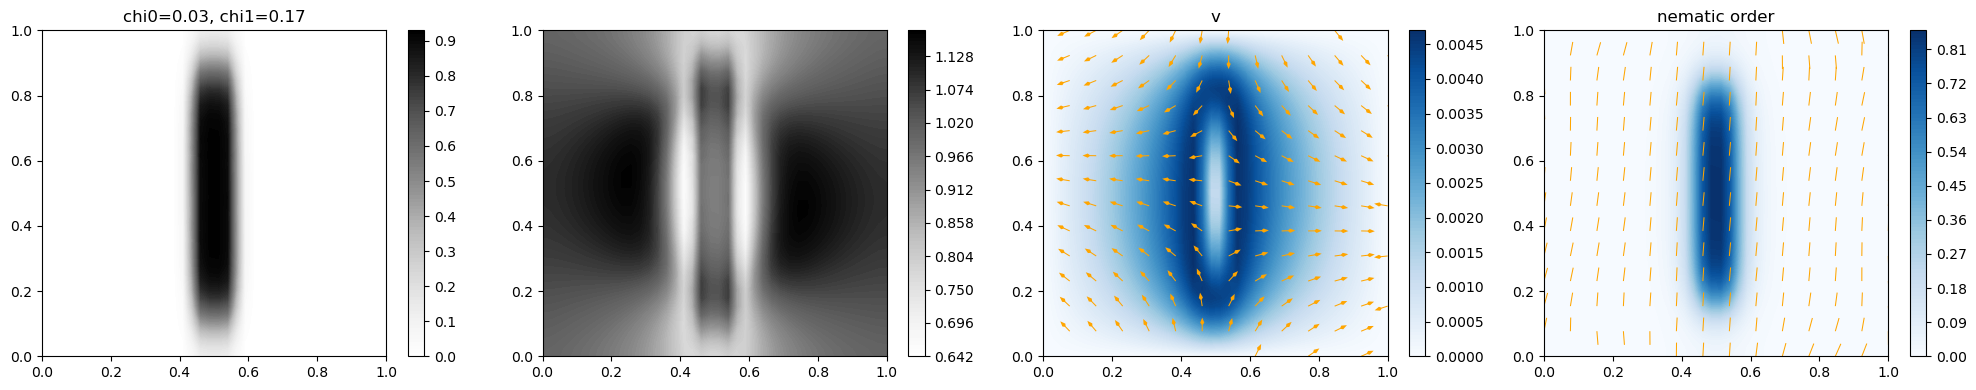

[ 0.51883356  1.         -0.83738224]


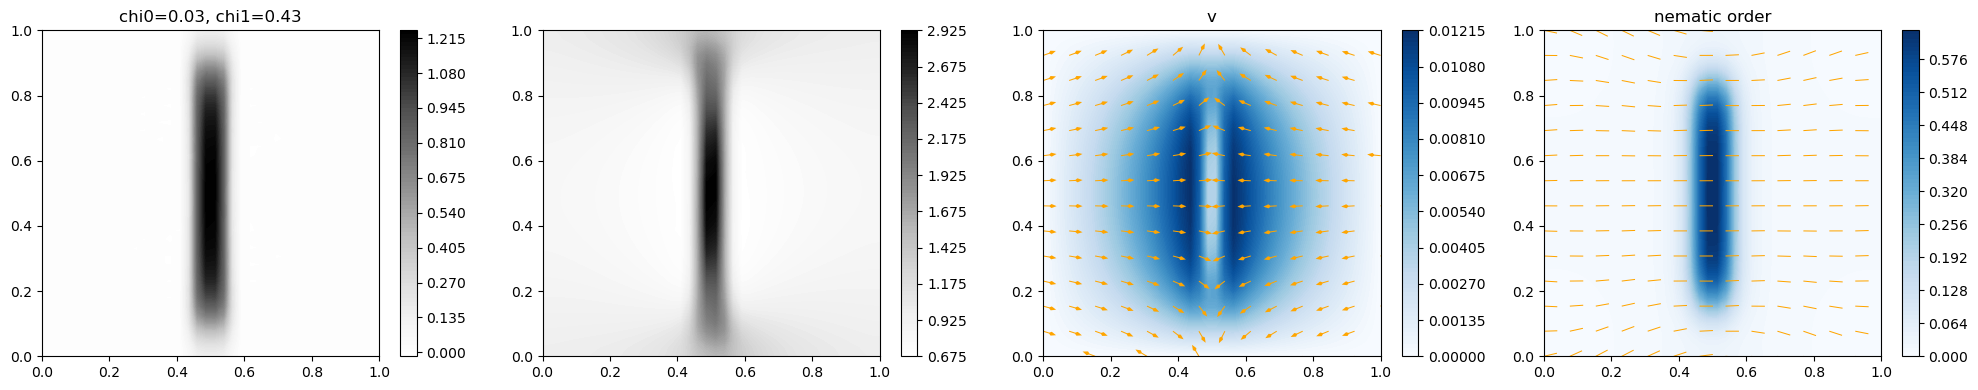

[ 2.23692523 -1.          0.62886465]


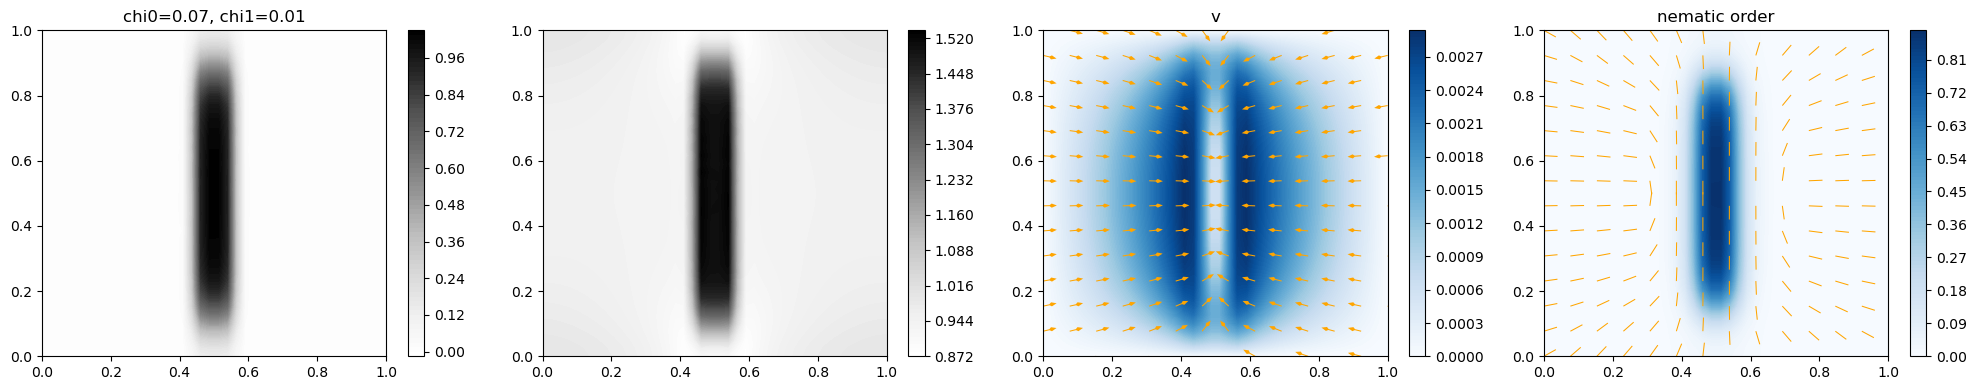

[ 0.65210341  0.         -0.88033965]


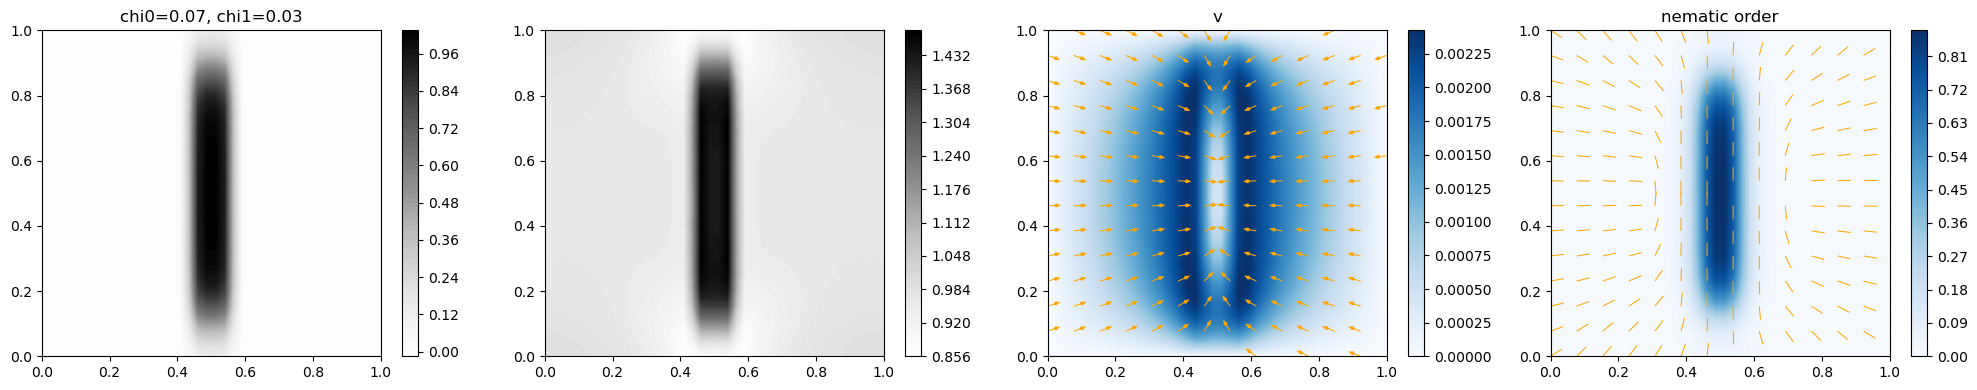

[ 0.61501706  0.         -0.87836517]


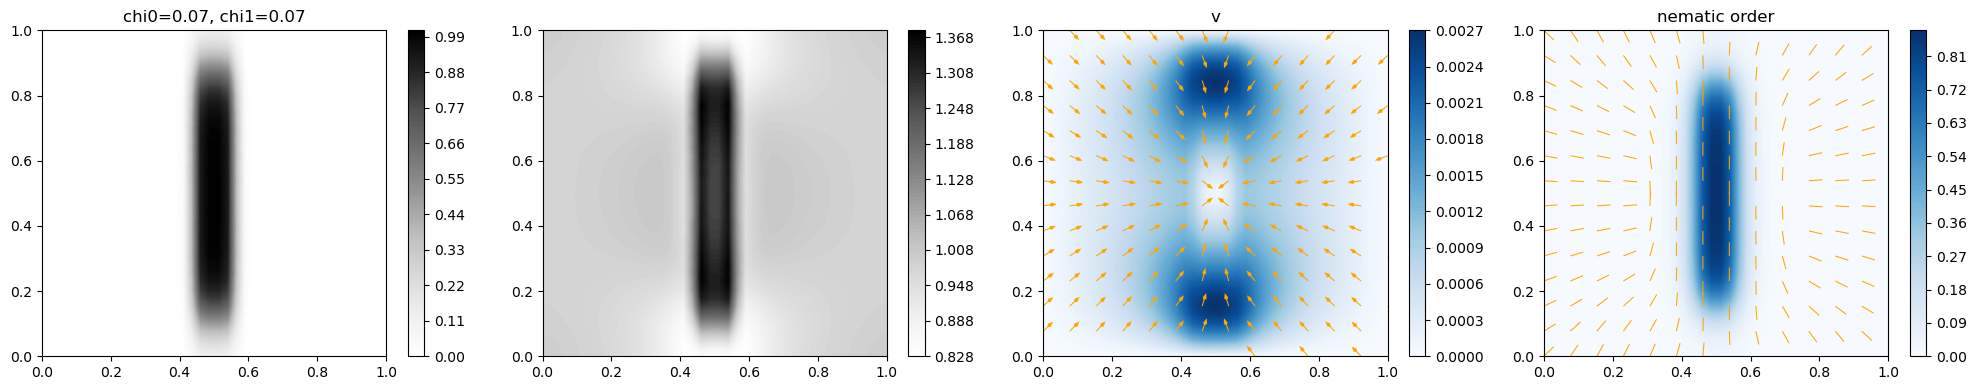

[ 0.54490012  0.         -0.87312657]


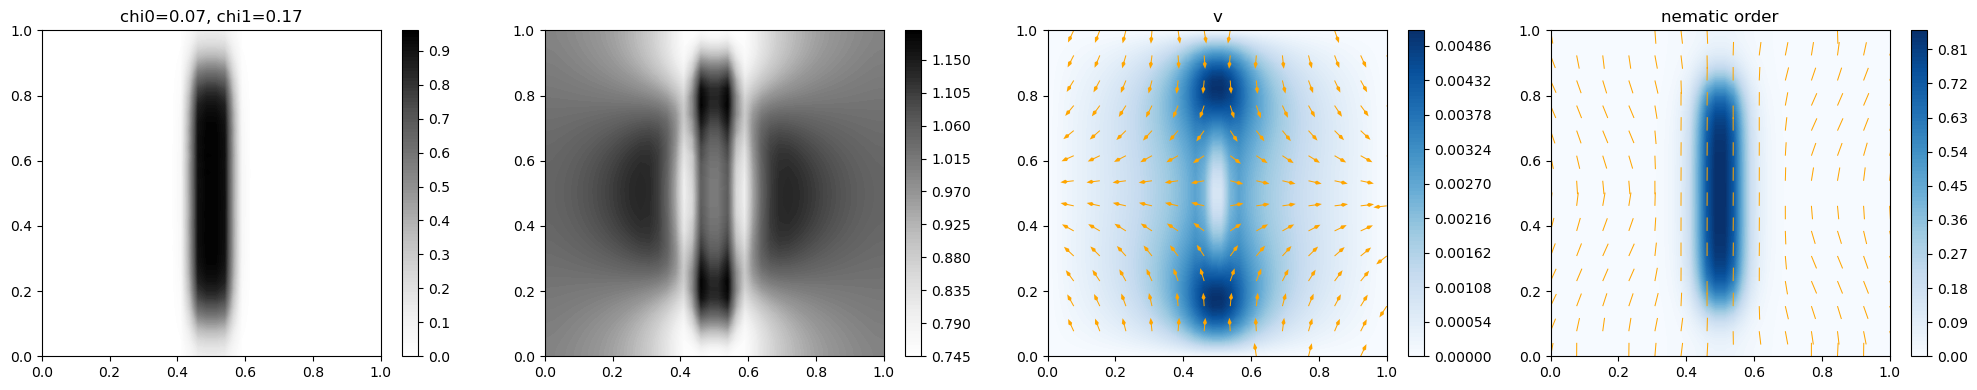

[ 0.44061016  1.         -0.85845676]


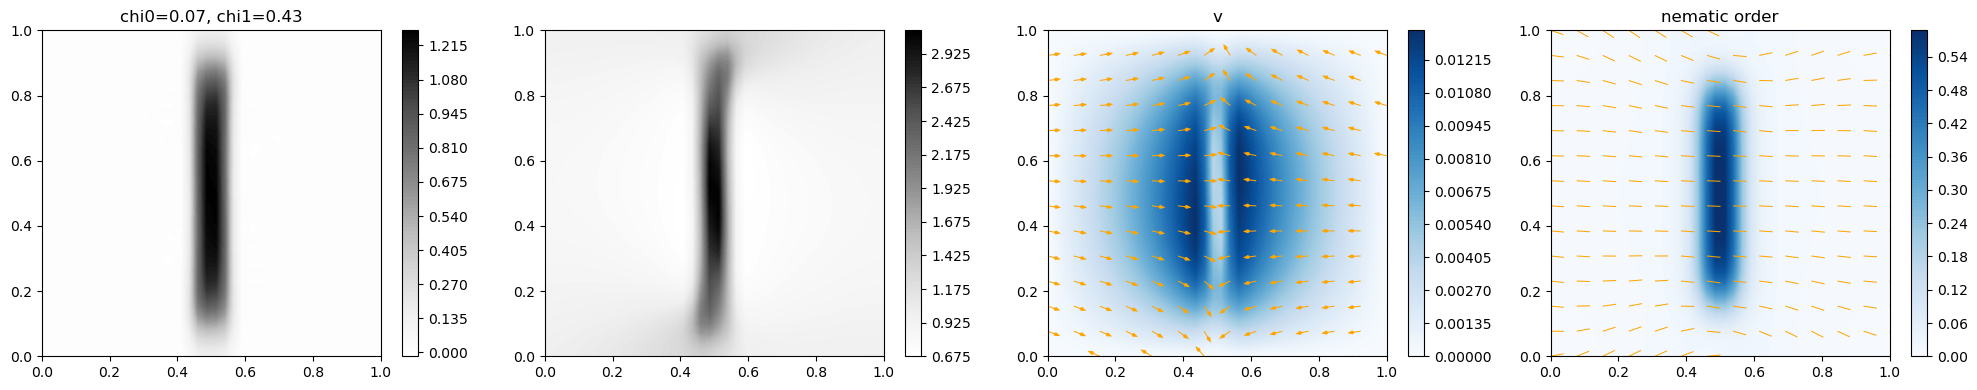

[ 2.4065883  -1.          0.58451917]


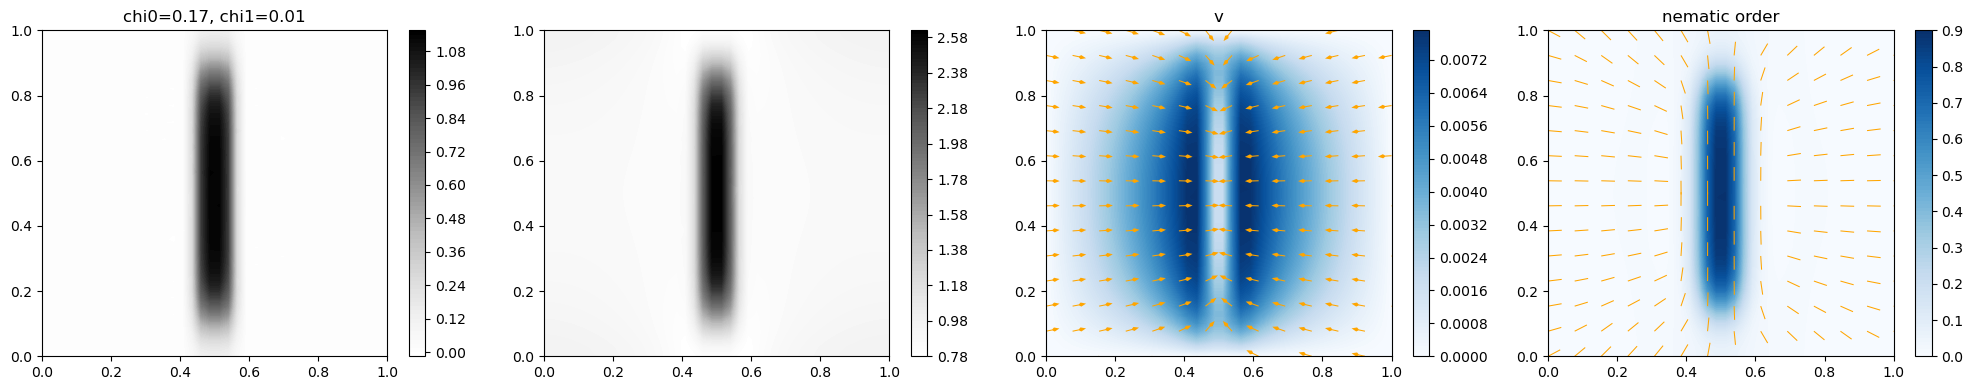

[ 1.82548403  0.         -0.88999149]


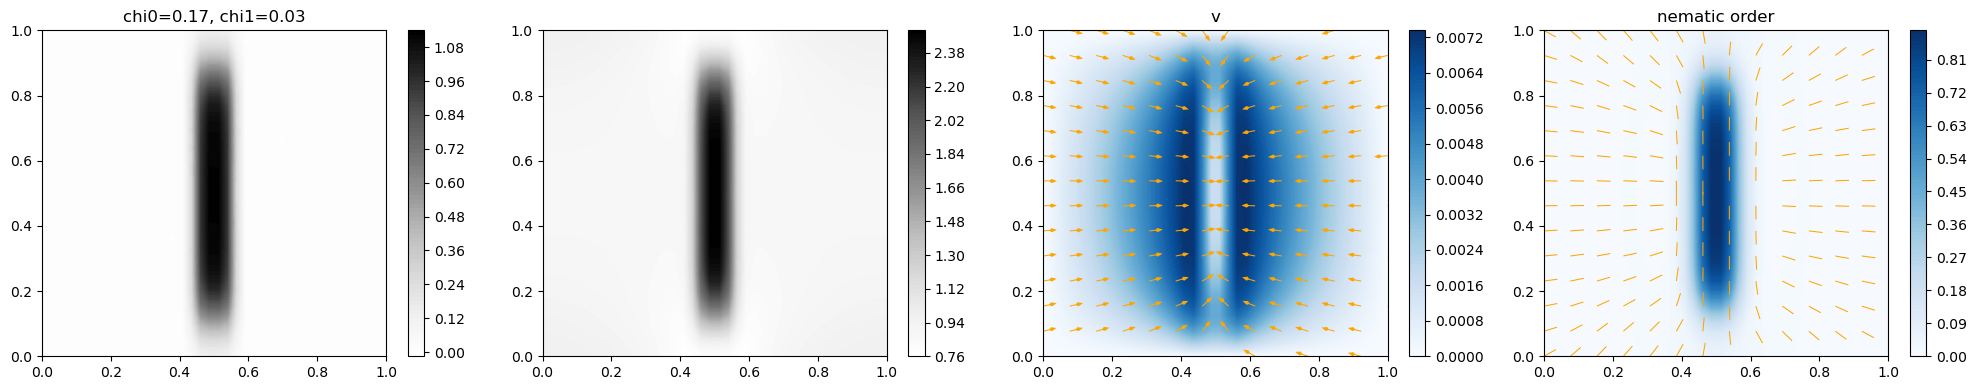

[ 1.72016875  0.         -0.88834808]


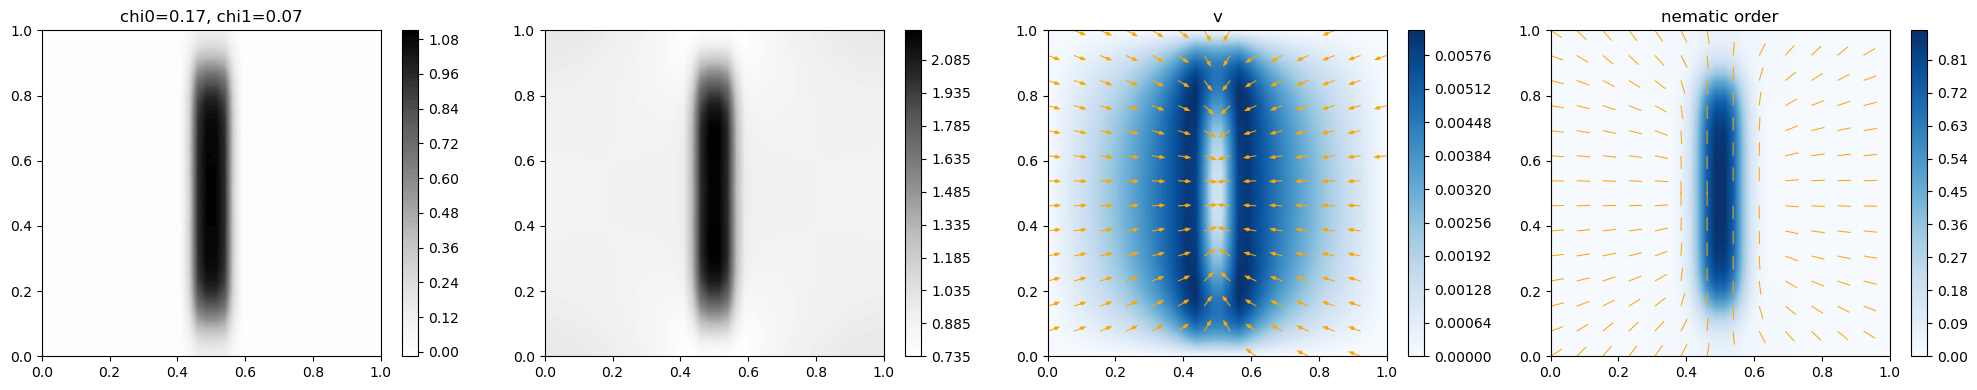

[ 1.47332631  0.         -0.88391163]


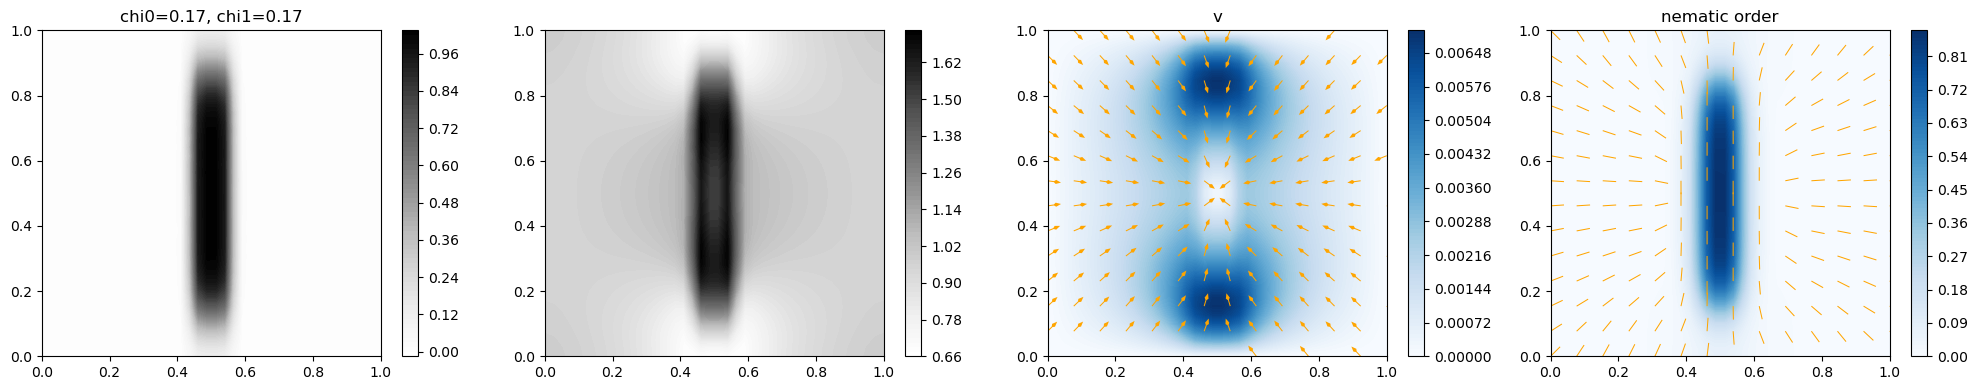

[ 1.03905731  0.         -0.87117625]


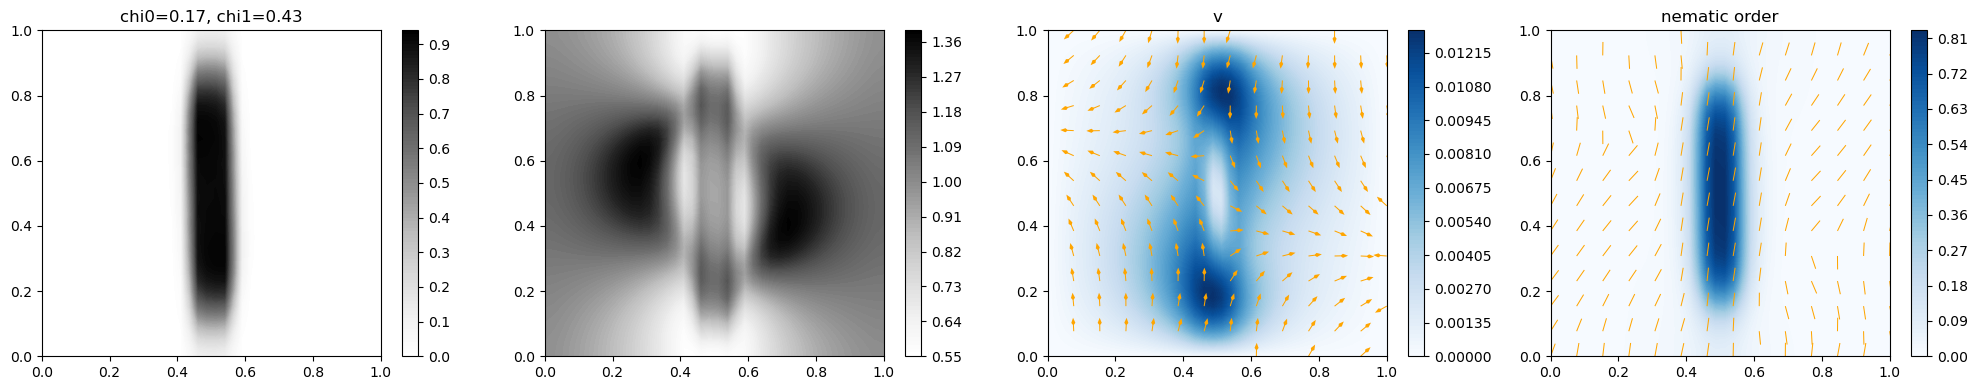

[ 0.83214001  1.         -0.76497998]


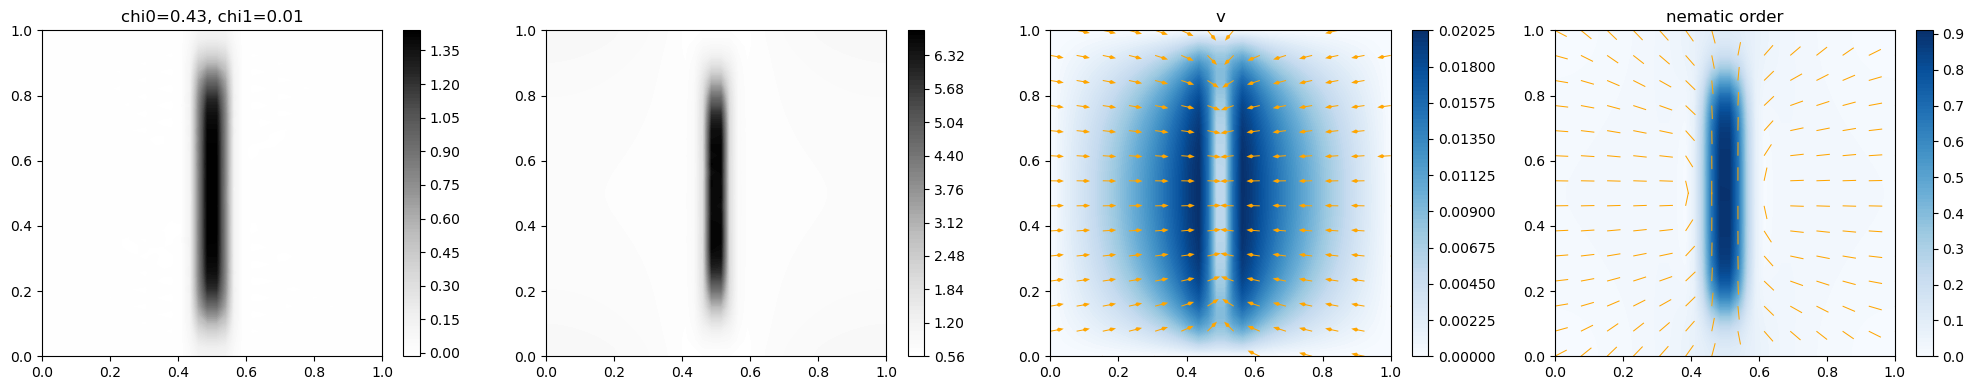

[ 6.11919845  0.         -0.90022132]


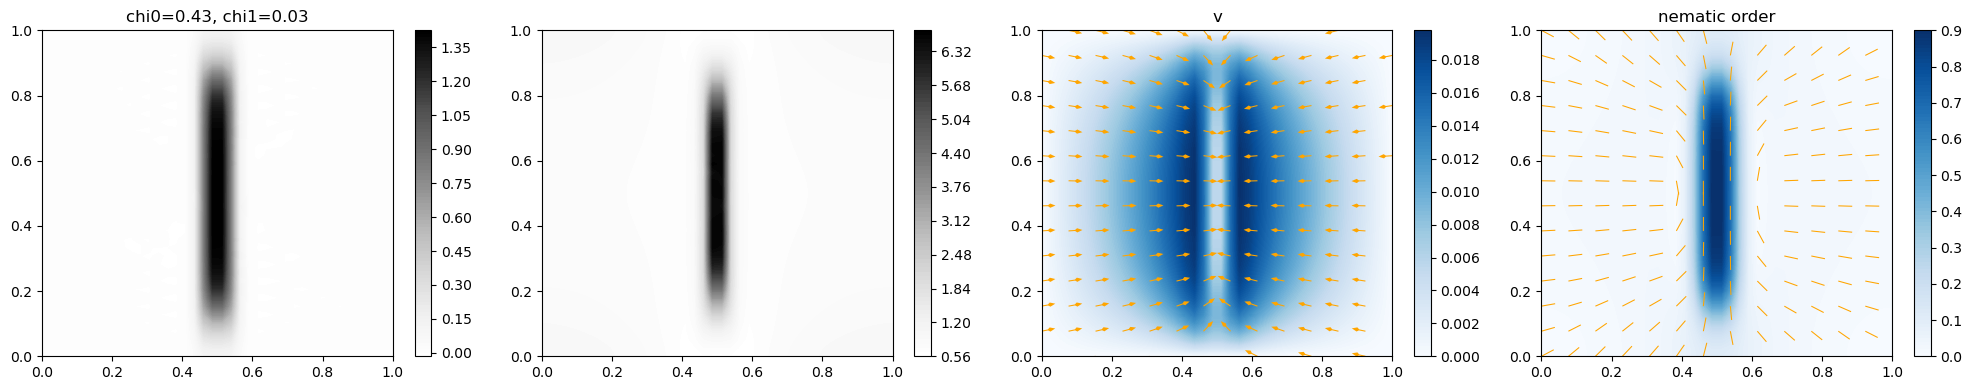

[ 6.07098496  0.         -0.89969034]


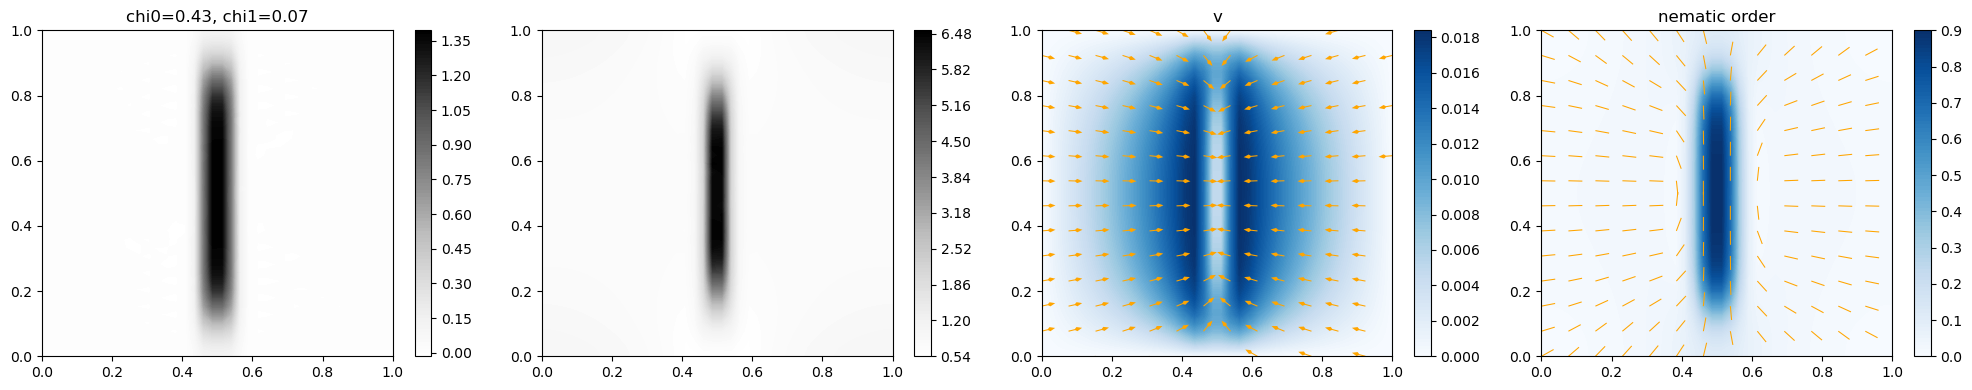

[ 5.92302385  0.         -0.89803484]


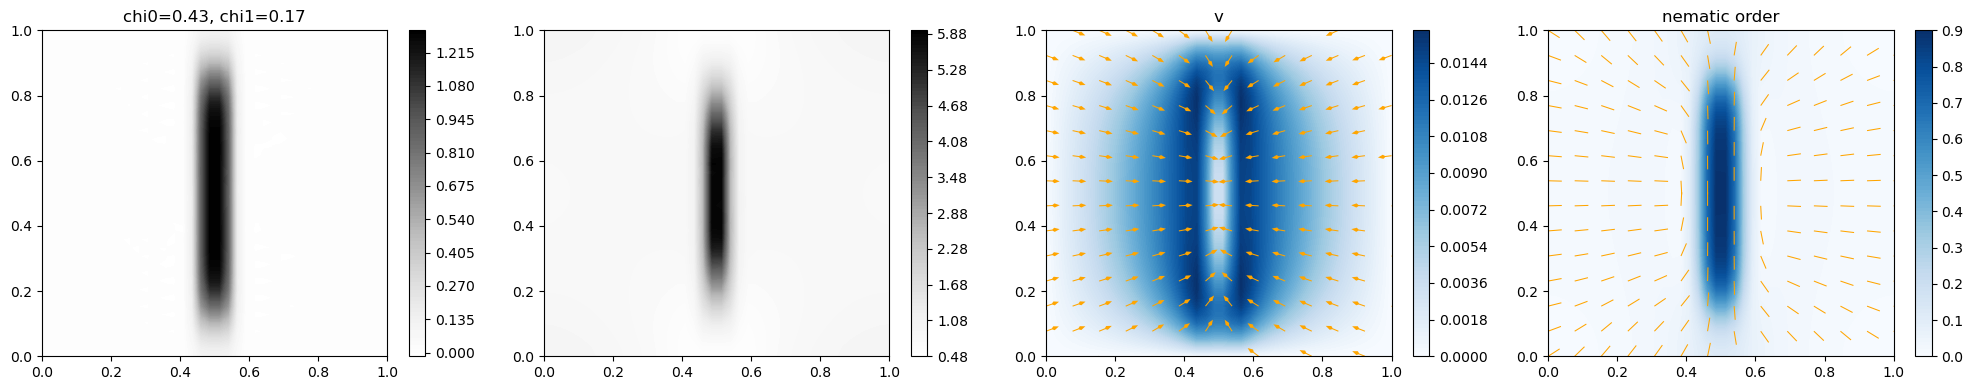

[ 5.35083621  0.         -0.89188659]


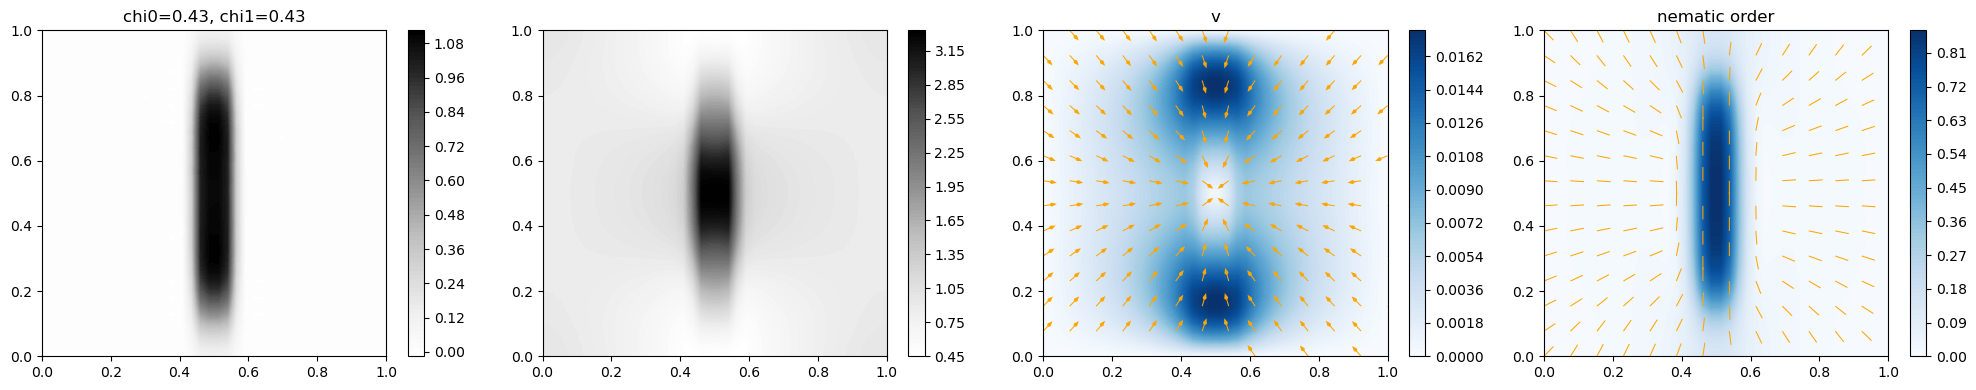

[ 2.87609749  0.         -0.86486969]


In [70]:
n_samples = 50 
exponents = np.linspace(np.log(0.01), 0, 50)
chis = np.exp(exponents)

for chi0_active in chis[::10]:
    for chi1_active in chis[::10]:       
        filename = 'sim_data/two_actin/chi0_{}_chi1_{}_kact_{}.npy'.format(chi0_active, chi1_active, k_actin)

        if os.path.isfile(filename):
            data = np.load(filename)
            rho, rho2, vx, vy, Q, q = np.rollaxis(data[-1], -1)
            nx, ny = utils.nematic_to_vector(Q, q)

            title = f"chi0={chi0_active:.2f}, chi1={chi1_active:.2f}"
            plot_frame(40, rho, rho2+rho, vx, vy, nx, ny, title=title, stride=3, save=False)
            print(extract_states(filename, shear_range=10))